## Generation of genetic interaction perturbation response

### (1) Train and load PerturbNet on genetic interaction data

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys
sys.path.append('../../..')
import time
import os
import random 

import torch
import torch.nn.functional as F
import torch.nn as nn

import anndata as ad
from scipy import sparse
import scvi
from sklearn.decomposition import PCA

from pytorch_scvi.distributions import *
from pytorch_scvi.scvi_generate_z import *

from perturbnet.perturb.util import * 
from perturbnet.genetic_perturb.cinn.modules.flow import * 
from perturbnet.genetic_perturb.genotypevae.genotypeVAE import *
from perturbnet.drug_perturb.cinn.modules.flow_generate import SCVIZ_CheckNet2Net


/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
path_data = 'data/GI/'
path_genovae_model = 'models/genotypevae/genotypevae/trained_models/model_params.pt'
path_scvi_model_train = 'models/cell_vae/GI/models_50Removed'
path_scvi_model_eval = 'models/cell_vae/GI/models_overall'
path_cinn_model = 'models/cinn/GI/ExpGIscVIFlowGenesSelected10Removed'

path_removed_per =  os.path.join(path_data, 'GI_50RemovedPerturbs_KeptPerturb_RAW_LibraryCheck_PyThon37.npy')


adata = ad.read_h5ad(os.path.join(path_data, 'GI_processed_KeptPerturb_RAW_LibraryCheck_NormBYHighGenes_processed.h5ad'))
scvi.data.setup_anndata(adata, layer = "counts")
scvi_model_eval = scvi.model.SCVI.load(path_scvi_model_eval, adata)

## meta information
## perturb with onehot
indices_with_onehot_data = pd.read_csv(os.path.join(path_data, 'indices_with_onehot_cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
indices_with_onehot = list(indices_with_onehot_data.iloc[:, 1])

### perturb list 
input_ltpm_label = pd.read_csv(os.path.join(path_data, 'cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
null_per_category = ['ctrl/ctrl', 'ctrl1/ctrl', 'ctrl10/ctrl', 'ctrl11/ctrl']
single_null_per_category = ['ctrl', 'ctrl1', 'ctrl10', 'ctrl11']

perturb_list = list(input_ltpm_label['perturbation'])
perturb1_list = []
perturb2_list = []
for i in range(len(perturb_list)):
    per1, per2 = perturb_list[i].split("/")
    perturb1_list.append(per1)
    perturb2_list.append(per2)

perturb1_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb1_list]
perturb2_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb2_list]

perturb_list_collect = [perturb1_list_collect[i] + "/" + perturb2_list_collect[i] for i in range(len(perturb2_list_collect))]
perturb_with_onehot_overall = np.array(perturb_list_collect)
perturb_with_onehot = perturb_with_onehot_overall[indices_with_onehot]

### removed perturbations 
removed_pers = np.load(path_removed_per)
removed_syn_pers = [i.split("/")[1] + '/' + i.split("/")[0] for i in removed_pers]
removed_all_pers = np.append(removed_pers, removed_syn_pers)

kept_indices = [i for i in range(len(perturb_with_onehot)) if perturb_with_onehot[i] not in removed_all_pers]
perturb_with_onehot_kept = perturb_with_onehot[kept_indices]

n_subsample = 300
adataKept = adata[indices_with_onehot, :].copy()
adataKept = adataKept[kept_indices, :].copy()[:n_subsample, :].copy()

scvi.data.setup_anndata(adataKept, layer = "counts")
scvi_model_cinn = scvi.model.SCVI.load(path_scvi_model_train, adataKept)
scvi_model_de = scvi_predictive_z(scvi_model_cinn)

## Onehot data
data_gi_onehot_all = np.load(os.path.join(path_data, "onehot_per_cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.npy"))
data_gi_onehot_kept = data_gi_onehot_all[indices_with_onehot][kept_indices]

## perturbation information data
perturb_data_pd = pd.Series(perturb_list_collect).str.get_dummies("/")
perturb_data = perturb_data_pd.values.astype('float64')

perturb_data_pd_rowunique = perturb_data_pd.drop_duplicates()
perturb_col_names = np.array(list(perturb_data_pd_rowunique.columns))

# treatment embedding
trt_list = np.load(os.path.join(path_data, "UniqueFromGeneAnnoOnehotTrt.npy"))
data_gi_onehot = np.load(os.path.join(path_data, "UniqueFromGeneAnnoOnehot.npy"))

# (2) load models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## GenotypeVAE
model_genovae = GenotypeVAE().to(device)
model_genovae.load_state_dict(torch.load(path_genovae_model, map_location = device))
model_genovae.eval()

flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 10,
                                         # condition dimensions 
                                         embedding_dim = 10, 
                                         conditioning_depth = 2, 
                                         n_flows = 20, 
                                         in_channels = 10, 
                                         hidden_dim = 1024, 
                                         hidden_depth = 2, 
                                         activation = "none", 
                                         conditioner_use_bn = True)


model_c = Net2NetFlow_scVIGenoFlow(configured_flow = flow_model,
                                   cond_stage_data = data_gi_onehot_kept[:n_subsample], 
                                   model_con = model_genovae, 
                                   scvi_model = scvi_model_cinn)



model_c.to(device = device)
#### load the model 
model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 109738 cells, 2279 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

GenotypeVAE(
  (linear_1): Linear(in_features=15988, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (linear_3_mu): Linear(in_features=256, out_features=10, bias=True)
  (linear_3_std): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=10, out_features=256, bias=True)
  (linear_5): Linear(in_features=256, out_features=512, bias=True)
  (linear_6): Linear(in_features=512, out_features=15988, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (leaky): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (dropout1): Dropout(p=0.2, inplace=F

In [3]:
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)

# (3) metrics
## PCA 
if sparse.issparse(adata.X):
    usedata = adata.X.A
else:
    usedata = adata.X

if sparse.issparse(adata.layers['counts']):
    usedata_count = adata.layers['counts'].A
else:
    usedata_count = adata.layers['counts']


pca_data_50 = PCA(n_components=50, random_state = 42)
pca_data_fit = pca_data_50.fit(usedata)

normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)
# (4) evaluation
Zsample = scvi_model_cinn.get_latent_representation(adata = adata, give_mean = False)
LSample = scvi_model_cinn.get_latent_library_size(adata = adata, give_mean = False)

indices_trt_removed = [i for i in range(len(trt_list)) if trt_list[i] in removed_all_pers]
indices_trt_kept = [i for i in range(len(trt_list)) if i not in set(indices_trt_removed)]

trt_obs_list, trt_unseen_list = np.array(trt_list)[indices_trt_kept], np.array(trt_list)[indices_trt_removed]

### (2) Evaluation

In [5]:
import umap
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

In [ ]:
## reconstruct data for a perturbation
indice_trt = 0
trt_type = trt_obs_list[indice_trt]

per1, per2 = trt_type.split('/')
other_trt_type = per2 + '/' + per1


idx_trt_type_1 = np.where(perturb_with_onehot_overall == trt_type)[0]
idx_trt_type_2 = np.where(perturb_with_onehot_overall == other_trt_type)[0]
idx_trt_type = np.concatenate((idx_trt_type_1, idx_trt_type_2))



onehot_indice_trt = np.tile(data_gi_onehot[indices_trt_kept][[indice_trt]], (len(idx_trt_type), 1))
_, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))


input_trt_latent, trt_onehot = Zsample[idx_trt_type], embdata_torch.cpu().detach().numpy()
library_trt_latent = LSample[idx_trt_type]
fake_latent, _ = perturbnet_model.recon_data(input_trt_latent, trt_onehot, library_trt_latent)

In [21]:
def tranUmap(latent_base, latent_new):
    """ function to umap embed new latents """
    trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(latent_base)
    x_embedded = trans.transform(np.concatenate((latent_base, latent_new)))
    
    return x_embedded

def plotUmap(x_embedded, label_base, label_new, n_label_base, ifPlotBoth = True):
    """Plot the Umap of latents"""
    
    category = np.append([label_base] * n_label_base, 
                         [label_new] * (x_embedded.shape[0] - n_label_base))
    df_umap_pr = x_embedded
    df_umap_pr = pd.DataFrame(df_umap_pr)
    df_umap_pr['x-umap'] =  x_embedded[:, 0]
    df_umap_pr['y-umap'] =  x_embedded[:, 1]
    df_umap_pr['Category'] = category

    min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
    max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())

    if ifPlotBoth:
        plotData = df_umap_pr
    else:
        plotData = df_umap_pr.iloc[n_label_base:, :]
        
    chart_pr = ggplot(plotData, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
            + geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
            + xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
            + theme(panel_background=element_rect(fill='white'), 
                    title=element_text(size = 25), 
                    axis_title_x=element_text(size = 15), 
                    axis_title_y=element_text(size = 15),
                    legend_title=element_text(size = 20), 
                    legend_text=element_text(size = 20),                                                                                                               
                    axis_text_y=element_blank(),
                    axis_text_x=element_blank(),                                                                                                     
                    axis_ticks_major_y=element_blank(),
                    axis_ticks_major_x=element_blank(),                                    
                    panel_grid=element_blank())\
            + guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))
    return chart_pr

def plotUmapOneCat(x_embedded, label_new, ifPlotBoth = True):
    """Plot the Umap of latents for one category"""
    
    category = [label_new] * (x_embedded.shape[0] )
    df_umap_pr = x_embedded
    df_umap_pr = pd.DataFrame(df_umap_pr)
    df_umap_pr['x-umap'] =  x_embedded[:, 0]
    df_umap_pr['y-umap'] =  x_embedded[:, 1]
    df_umap_pr['Category'] = category

    min_x, min_y = np.floor(df_umap_pr['x-umap'].min()), np.floor(df_umap_pr['y-umap'].min())
    max_x, max_y = np.ceil(df_umap_pr['x-umap'].max()), np.ceil(df_umap_pr['y-umap'].max())


        
    chart_pr = ggplot(df_umap_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Category') ) \
            + geom_point(size=0.1, alpha = 1) + labs(x = "UMAP1", y = "UMAP2") \
            + xlim(min_x, max_x) + ylim(min_y, max_y) + theme_bw()\
            + theme(panel_background=element_rect(fill='white'), 
                    title=element_text(size = 25), 
                    axis_title_x=element_text(size = 15), 
                    axis_title_y=element_text(size = 15),
                    legend_title=element_text(size = 20), 
                    legend_text=element_text(size = 20),                                                                                                               
                    axis_text_y=element_blank(),
                    axis_text_x=element_blank(),                                                                                                     
                    axis_ticks_major_y=element_blank(),
                    axis_ticks_major_x=element_blank(),                                    
                    panel_grid=element_blank())\
            + guides(colour=guide_legend(nrow=3, override_aes={"size": 10}))
    return chart_pr

#### transite cell responses of this perturbation to another perturbation 

In [22]:
per1, per2 = trt_type.split('/')
other_trt_type = per2 + '/' + per1

idx_trt_type_1 = np.where(perturb_with_onehot_overall == trt_type)[0]
idx_trt_type_2 = np.where(perturb_with_onehot_overall == other_trt_type)[0]
idx_trt_type = np.concatenate((idx_trt_type_1, idx_trt_type_2))
input_trt_latent_other = Zsample[idx_trt_type]

In [30]:
idx_random = np.random.choice(range(Zsample.shape[0]), 3000)
input_random = Zsample[idx_random]
input_random.shape

(3000, 10)

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


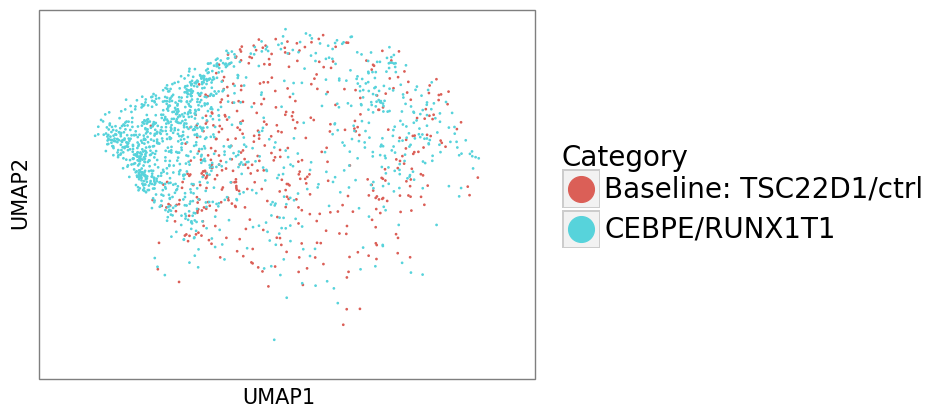

<ggplot: (2949010933637)>

In [38]:
x_embedded = tranUmap(input_random, np.concatenate((input_trt_latent, input_trt_latent_other)))
plotUmap(x_embedded[3000:], 'Baseline: TSC22D1/ctrl', 'CEBPE/RUNX1T1', n_label_base = input_trt_latent.shape[0])

In [57]:
trt_type = 'CEBPE/RUNX1T1'

In [58]:
trt_list[indices_trt_removed][[indice_trt]], trt_list[indices_trt_kept][[indice_trt]]

(array(['CEBPE/RUNX1T1'], dtype='<U15'), array(['TSC22D1/ctrl'], dtype='<U15'))

In [59]:

per1, per2 = trt_type.split('/')
other_trt_type = per2 + '/' + per1


idx_trt_type_1 = np.where(perturb_with_onehot_overall == trt_type)[0]
idx_trt_type_2 = np.where(perturb_with_onehot_overall == other_trt_type)[0]
idx_trt_type_other = np.concatenate((idx_trt_type_1, idx_trt_type_2))

## PerturbNet

onehot_indice_trt = np.tile(data_gi_onehot[indices_trt_removed][[indice_trt]], (len(idx_trt_type_other), 1))
_, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))

## recon data
trt_onehot_other = embdata_torch.cpu().detach().numpy()

In [60]:
library_trt_latent_other = LSample[idx_trt_type_other]

In [61]:
indice_trt = 0

## Method1
onehot_indice_trt_otherTo = np.tile(data_gi_onehot[indices_trt_kept][[indice_trt]], (len(idx_trt_type_other), 1))
_, _, _, embdata_torch_otherTo = model_g(torch.tensor(onehot_indice_trt_otherTo).float().to(device))

## recon data
trt_onehot_otherTo = embdata_torch_otherTo.cpu().detach().numpy()


In [63]:
fake_latent_other, _ = perturbnet_model.trans_data(input_trt_latent_other, trt_onehot_other, 
                                                   trt_onehot_otherTo, 
                                                   library_trt_latent_other)

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


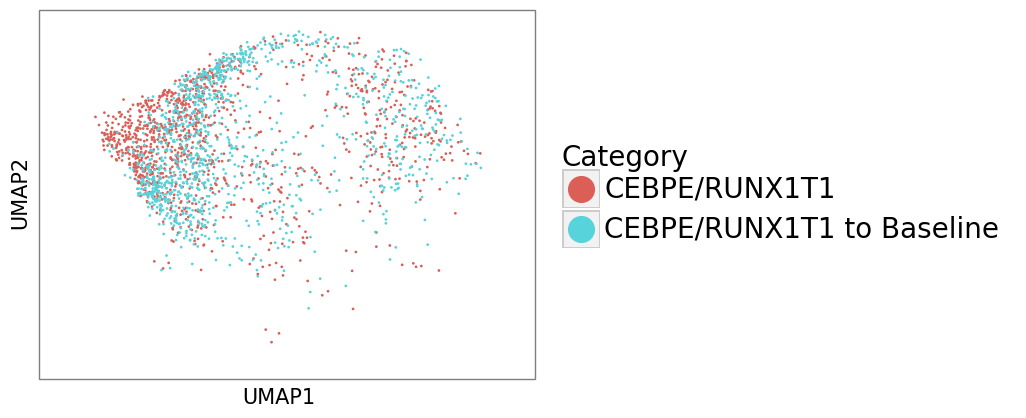

<ggplot: (2949015349664)>

In [66]:
x_embedded = tranUmap(input_random, np.concatenate((input_trt_latent_other, fake_latent_other)))
plotUmap(x_embedded[3000:], 'CEBPE/RUNX1T1', 'CEBPE/RUNX1T1 to Baseline', n_label_base = input_trt_latent_other.shape[0])

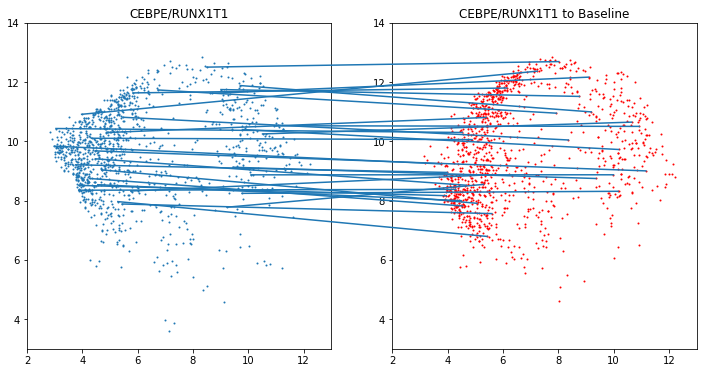

In [71]:
min_x, min_y = np.floor(x_embedded[:, 0].min()), np.floor(x_embedded[:, 1].min())
max_x, max_y = np.ceil(x_embedded[:, 0].max()), np.ceil(x_embedded[:, 1].max())


fig = plt.figure(figsize = (12, 6))

ax1 = plt.subplot(121)

plt.scatter(x_embedded[3000: 3000 + input_trt_latent_other.shape[0], 0], 
            x_embedded[3000: 3000 + input_trt_latent_other.shape[0], 1],
            s = 1, label = 'CEBPE/RUNX1T1')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('CEBPE/RUNX1T1')

ax2 = plt.subplot(122)
plt.scatter(x_embedded[3000 + input_trt_latent_other.shape[0]: , 0], 
            x_embedded[3000 + input_trt_latent_other.shape[0]:, 1], s = 1, label = 'S1172', color = 'red')

#plt.legend('topleft')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('CEBPE/RUNX1T1 to Baseline')

transFigure = fig.transFigure.inverted()
for i in range(30): #range(input_trt_latent_other.shape[0]):
    xy1 = transFigure.transform(ax1.transData.transform([x_embedded[3000: 3000 + input_trt_latent_other.shape[0]][i, 0], 
                                                         x_embedded[3000: 3000 + input_trt_latent_other.shape[0]][i, 1]]))
    xy2 = transFigure.transform(ax2.transData.transform([x_embedded[3000 + input_trt_latent_other.shape[0]:][i, 0], 
                                                         x_embedded[3000 + input_trt_latent_other.shape[0]:][i, 1]]))

    line = matplotlib.lines.Line2D((xy1[0],xy2[0]),(xy1[1],xy2[1]),
                                   transform = fig.transFigure)
    fig.lines.append(line)